<h1> Task 2, Least Squares Monte Carlo </h1>

Calcualte BOPM on american call and puts
<br>
Use BSM on European put and calls, and compare to the sim's.
<br>
<br>
Use LSMC on american call and put
<br>
<br>
sim 10'000 paths use LSMC on american call
<br>
some stats
<br>
<br>
more stats

In [590]:
from source_code.ex1_code import *
from source_code.ex3_code import *
import pandas as pd

<h2> 2.1

In [591]:
#BOPM call
ex2ai1 = BinPriMod(200,210,0.2,3,3,0.05,'Call','American',)
ex2ai1.set_dividends(cont=True, cont_rate=0.01, TD=None, amount=None)
ex2ai1.storage_values(False)
A_ex2ai1 = ex2ai1.storage_prices(True)[0]
#BOPM put
ex2ai2 = BinPriMod(200,210,0.2,3,3,0.05,'Put','American',)
ex2ai2.set_dividends(cont=True, cont_rate=0.01, TD=None, amount=None)
ex2ai2.storage_values(False)
A_ex2ai2 = ex2ai2.storage_prices(True)[0]
#BSM call
ex2aii1 = BlaSchMet(200,210,3,0.05,0.01,'Call')
ex2aii1.set_goal(find_price=True,vol=0.2,find_vol=False,price=None)
A_ex2aii1 = ex2aii1 .call_black_scholes()
#BSM put
ex2aii1 = BlaSchMet(200,210,3,0.05,0.01,'Put')
ex2aii1.set_goal(find_price=True,vol=0.2,find_vol=False,price=None)
A_ex2aii2 = ex2aii1.call_black_scholes()

c:\Users\Jakob\anaconda3\lib\site-packages\numpy\lib\function_base.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


In [592]:
pd.DataFrame({'BSM':[A_ex2aii1,A_ex2aii2],
              'BOPM':[A_ex2ai1, A_ex2ai2]}, index=['Call','Put'])

,BSM,BOPM
Call,32.979069,[38.81]
Put,19.638638,[25.47]


<h2> 2.2

In [781]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [1336]:
class LeaSquMonCar():
    def __init__(self, S, K, T, vol, rf,  div_y, option_type, paths, time_steps):
        self.spot = S
        self.strike = K
        self.total_time = T
        self.volatility = vol
        self.risk_free =  rf
        self.dividend_yield = div_y
        self.paths = paths
        self.time_steps = time_steps
        self.h =  self.total_time/self.time_steps
        self.option_type = option_type
        self.pathdf =  None
    
    def CreatePaths(self,post=None):
        path_list = []
        for path in range(self.paths):
            path_i = [self.spot]
            for steps in range(self.time_steps):
                part1 = (self.risk_free-self.dividend_yield*(1/2)*self.volatility**2)*self.h
                part2 = np.random.normal(0,1)
                part3 = self.volatility * np.sqrt(self.h)*part2
                S_t = path_i[-1]*np.e**(part1+part3)
                path_i.append(S_t)
            path_list.append(path_i)
        pathsdf = pd.DataFrame(path_list).T
        self.pathdf = pathsdf
        if post == True:
            return  pathsdf
        
    def regress(self, X, Y):
        Xsq = X**2
        df = pd.DataFrame({'id':np.arange(self.paths),
                        'Y':Y,
                        'X':X,
                        'Xsq':Xsq})
        if self.option_type =='Put':
            df=df[df['X']>self.strike]
        else:
            df=df[df['X']<self.strike]

        train = sm.add_constant(df[['X','Xsq']])
        model = sm.OLS(df['Y'],train).fit()
        print(train.shape)
        cond_exp = model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq']
        return cond_exp
        
    def LeastSquares(self):
        iddf = self.pathdf.T
        iddf['id'] = np.arange(self.paths)
        Payoff_df = iddf
        disc_r = np.e**((-self.risk_free+self.dividend_yield)*self.h)


        for i in range(0,self.time_steps,1):
            data_retY = iddf[self.time_steps-i]
            data_retX = iddf[self.time_steps-(i+1)]

            if self.option_type == 'Call':
                if i==0:
                    Y =np.where(data_retY-self.strike>0,data_retY-self.strike,0)*disc_r
                else:
                    Y = Payoff_df[self.time_steps-i]*disc_r
                    # if i==1:
                        # print(Y)
                X = np.where(data_retX-self.strike>0,data_retX,0)
            # if self.option_type == 'Put':
            #     if i == 0:
            #         Y =np.where(data_retY-self.strike<0,data_retY-self.strike,0)*disc_r
            #     else:
            #         Y = Payoff_df[self.paths-i]*disc_r
            #     X = np.where(data_retX-self.strike<0,data_retX,0)
            cond_exp  = self.regress(X,Y)
            zeros = pd.Series(np.zeros(self.paths))
            zeros.loc[cond_exp.index] =  cond_exp

            if i == 0:
                Payoff_df[self.time_steps-i] = Y
            Payoff_df[self.time_steps-i-1] = np.where(zeros>Y,zeros,0)
        
        return Payoff_df

In [1337]:
lsmc = LeaSquMonCar(200,210,1,0.2,0.05,0.01,'Call',1000,4)
k = lsmc.CreatePaths(post=True)
hei = lsmc.LeastSquares()

(512, 3)
(559, 3)
(626, 3)
(1000, 3)


In [1332]:
k.T

,0,1,2,3,4
0,200.0,190.080400,174.293597,164.924047,155.362540
1,200.0,219.174082,210.804266,194.434692,230.689313
2,200.0,217.339329,185.585669,187.919310,169.000134
3,200.0,207.573614,175.781160,177.601751,191.265565
4,200.0,203.381722,207.431777,257.108548,267.445460
5,200.0,217.782386,225.300110,240.276121,227.098408
6,200.0,249.851456,284.912375,275.811345,276.527741
7,200.0,219.677773,268.811782,292.244280,327.811012
8,200.0,212.458835,215.234338,211.138890,202.466199
9,200.0,196.622920,180.906271,166.849077,184.537951


In [1333]:
hei

,0,1,2,3,4,id
0,0.000000,0.803114,0.000000,4.09669,0.000000,0
1,0.238537,0.000000,0.000000,0.00000,20.483451,1
2,0.238537,0.000000,0.000000,4.09669,0.000000,2
3,0.000000,0.803114,0.000000,4.09669,0.000000,3
4,0.238537,0.000000,3.244742,0.00000,56.873868,4
5,0.238537,0.000000,0.000000,0.00000,16.928276,5
6,0.238537,0.000000,0.000000,0.00000,65.865779,6
7,0.238537,0.000000,0.000000,0.00000,116.638773,7
8,0.238537,0.000000,0.000000,0.00000,0.000000,8
9,0.000000,0.803114,0.000000,4.09669,0.000000,9


In [1262]:
# hei.

In [1251]:
k.T[100-1]

0      208.553286
1      244.350427
2      157.102082
3      235.669845
4      302.973698
          ...    
995    183.261637
996    210.715993
997    216.451872
998    235.192268
999    218.256979
Name: 99, Length: 1000, dtype: float64

In [1247]:
hei

array([], shape=(0, 101), dtype=float64)

In [879]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [1171]:
Y = np.where(k.T.iloc[:,-1]-210>0, k.T.iloc[:,-1]-210,0)

In [1344]:
def conditional_exp():
    Y = np.where(k.T.iloc[:,-1]-210>0, k.T.iloc[:,-1]-210,0)
    X = np.where(k.T.iloc[:,-2]-210>0, k.T.iloc[:,-2],0)
    Xsq = X**2
    df = pd.DataFrame({'id':np.arange(1000),
                    'Y':Y,
                    'X':X,
                    'Xsq':Xsq})
    df=df[df['X']>210]

    train = sm.add_constant(df[['X','Xsq']])
    model = sm.OLS(df['Y'],train).fit()
    cond_exp = model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq']
    return cond_exp
    # return X
ans = conditional_exp()

In [1347]:
zeros = pd.Series(np.zeros(1000))
zeros.loc[ans.index] =  ans

In [1354]:
k.T[3]-210

0     -52.341324
1      -6.403617
2     -11.211957
3     -20.685782
4      -5.496482
         ...    
995   -48.786262
996    17.520935
997   -63.554106
998   -68.901071
999    10.129414
Name: 3, Length: 1000, dtype: float64

In [1353]:
ans

6       30.150865
7      120.357876
12      14.393518
13      23.897637
17      13.181957
          ...    
992     19.535424
993     33.822335
994     19.123581
996     23.546192
999     16.520661
Length: 488, dtype: float64

In [1356]:
k.T[3]-210-ans

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
995         NaN
996   -6.025256
997         NaN
998         NaN
999   -6.391247
Length: 1000, dtype: float64

In [1346]:
k.T[3]

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
995           NaN
996    203.974744
997           NaN
998           NaN
999    203.608753
Length: 1000, dtype: float64

In [1178]:
np.where(zeros>Y,zeros,0)

array([  0.        ,  31.7224854 ,   0.        ,   0.        ,
         6.45364506,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  15.04480982,
        22.40052697,  56.81678342,   0.        ,   0.        ,
         0.        ,  73.48731904,  81.49917616,   0.        ,
       110.74718314,  37.63742149,  60.07719179,  90.05732025,
         0.        ,   0.        ,   0.        ,   0.        ,
        20.61529588,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        28.37133323,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  43.39264556,
         0.        ,   0.        ,   0.        ,   0.        ,
         1.71033068,   5.8374949 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [1176]:
zeros = pd.Series(np.zeros(1000))
zeros.loc[ans.index] =  ans
zeros

0       0.000000
1      31.722485
2       0.000000
3       0.000000
4       6.453645
         ...    
995    39.919772
996     0.000000
997    35.897040
998     3.164965
999     0.000000
Length: 1000, dtype: float64

In [1154]:
O_df = k.T
O_df[100] = Y
O_df[99] = zeros


In [1155]:
O_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,200.0,202.603035,200.921814,195.561419,200.161973,201.859874,194.413651,191.917996,202.831248,203.614087,...,239.067728,237.377527,228.482698,235.350777,229.912861,228.846315,224.650204,225.392379,21.592862,0.000000
1,200.0,204.148441,204.333357,206.049221,200.394745,202.280965,198.343355,200.326991,206.808617,213.792211,...,167.860382,166.164733,172.239133,169.954093,169.300282,171.605643,173.399792,176.390725,0.000000,0.000000
2,200.0,203.090766,206.071670,205.185886,211.929679,214.684061,213.865712,213.326905,211.984202,213.464511,...,259.949181,271.378948,258.279213,252.303483,257.123448,257.821968,250.764120,259.031106,52.079827,13.486870
3,200.0,202.827370,205.789060,206.124209,210.799670,218.443184,217.926471,217.500560,214.931225,211.781179,...,193.812041,199.222509,201.302225,200.954911,197.655106,196.656235,195.395902,194.712975,0.000000,54.647976
4,200.0,205.267576,205.764354,212.078335,218.705798,227.536180,222.419811,219.624721,211.115918,214.264912,...,251.616581,252.672079,248.423647,256.702264,256.927279,264.479062,260.000148,260.770592,53.589698,59.822230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200.0,205.013094,204.996956,208.154026,209.240503,208.819045,210.497696,204.349254,208.131047,209.742837,...,166.703692,166.434251,159.648187,155.766758,156.403740,157.833697,160.563898,163.966309,0.000000,0.000000
996,200.0,199.876127,203.379556,208.907953,205.410980,212.746878,212.211769,209.980628,209.787861,208.631670,...,258.282086,265.610215,263.676437,268.726587,267.708672,264.137679,263.415628,268.783725,59.785464,66.390685
997,200.0,203.901527,207.469222,209.741453,210.729013,208.435507,209.391385,203.640737,207.448317,217.523046,...,209.490018,210.488882,207.045060,202.340265,202.469154,204.082071,201.743193,198.554241,0.000000,105.891630
998,200.0,201.596099,197.949526,202.588710,199.468586,195.180136,192.957670,191.843118,194.423848,193.542437,...,225.639997,230.669386,225.461800,230.135843,223.860813,221.915432,219.715799,212.838200,0.000000,26.331530


In [1084]:
O_df = k.T
O_df['id'] = np.arange(1000)
# O_df.head(2)

In [1094]:
O_df['id'][ans.index]

2        2
3        3
4        4
8        8
9        9
      ... 
992    992
996    996
997    997
998    998
999    999
Name: id, Length: 526, dtype: int32

In [1057]:
B_df = k.T
B_df['id'] = np.arange(1000)
B_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,id
0,200.0,201.487019,198.623045,197.063033,194.993096,193.772121,198.196304,199.075500,201.547265,205.660915,...,186.756461,185.946797,195.042593,193.156919,194.793968,193.078263,191.584751,199.665066,203.771750,0
1,200.0,198.472394,193.654662,193.515050,188.968069,188.137960,188.293081,184.432329,185.517172,181.732651,...,195.781271,195.393957,188.212440,186.830093,186.186214,184.685334,184.105181,185.800126,191.598807,1


In [1072]:
PO_df = k.T
PO_df['id'] = np.arange(1000)
PO_df[100] = Y
PO_df
# PO_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,id
0,200.0,201.487019,198.623045,197.063033,194.993096,193.772121,198.196304,199.075500,201.547265,205.660915,...,186.756461,185.946797,195.042593,193.156919,194.793968,193.078263,191.584751,199.665066,0.000000,0
1,200.0,198.472394,193.654662,193.515050,188.968069,188.137960,188.293081,184.432329,185.517172,181.732651,...,195.781271,195.393957,188.212440,186.830093,186.186214,184.685334,184.105181,185.800126,0.000000,1
2,200.0,195.355991,198.214845,205.205957,201.452843,199.706172,196.755559,208.044357,202.060416,204.058610,...,220.471237,220.945114,220.012449,222.110266,223.348506,218.659222,227.692081,230.443822,13.486870,2
3,200.0,199.211409,190.899800,190.539165,183.239508,182.476098,186.001869,181.456737,185.296297,189.958635,...,247.353441,249.222050,257.017137,258.679287,258.232885,270.070962,266.614678,265.975862,54.647976,3
4,200.0,206.173959,202.555710,196.362601,200.539165,202.818485,208.928527,209.026552,204.826914,212.574033,...,265.766150,267.934339,265.157308,268.208474,271.905493,274.268429,276.185407,273.619256,59.822230,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200.0,203.167161,202.675174,205.735493,202.830698,210.300437,217.388476,225.267052,228.076912,224.952127,...,204.382326,199.737785,188.573845,188.216738,188.872739,187.706153,190.127600,187.615171,0.000000,995
996,200.0,203.726659,199.086193,204.331981,201.356135,197.970455,197.684542,199.810232,188.386650,193.190796,...,273.071386,267.831998,265.694690,271.435787,280.246603,273.966014,275.952604,272.640562,66.390685,996
997,200.0,203.466606,203.342756,206.483638,207.523415,209.856469,214.184561,215.248997,223.121454,223.558505,...,313.523247,303.059733,296.260571,302.850277,301.308330,301.307183,305.622069,310.358570,105.891630,997
998,200.0,201.450724,201.197975,206.461259,204.619358,203.810990,201.783759,201.289373,200.203999,196.744456,...,222.203480,236.069507,235.713000,238.970646,241.575862,244.766158,235.044813,243.670186,26.331530,998


In [986]:
# bravo = alfa['id'][df['id']].index 

In [985]:
# np.where(alfa[100]==bravo)

(-0.01, 0.01)

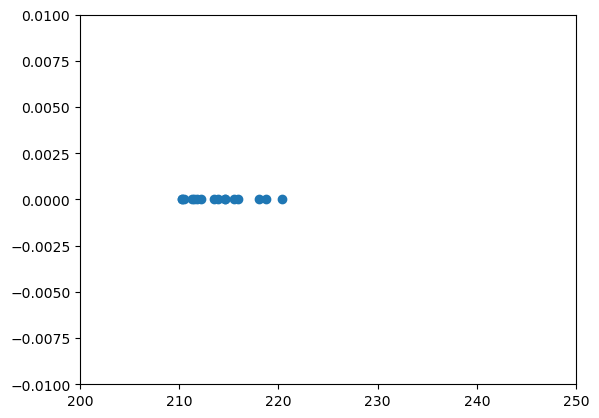

In [850]:
plt.scatter(X,Y)
plt.xlim(200,250)
plt.ylim(-0.01,0.01)

In [817]:
np.where(X-210>0,X-210,0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  7.98094129,  9.376824  ,  9.06732104,
        5.49129684, 11.5085016 ,  5.49896954,  6.25112407,  4.50353296,
        7.25104448, 10.62557876, 10.91080428, 11.7917145 , 15.49732306,
       10.95834899, 11.80425633, 10.31582365,  3.86294069,  9.19303897,
        8.94255744, 11.0257323 ,  3.02542172,  0.        ,  0.49454615,
        4.58255114,  1.28232394,  0.        ,  0.        ,  0.        ,
        0.23163886,  0.        ,  0.        ,  0.        ,  0.        ,
        2.13629645,  0.        ,  0.        ,  0.        ,  1.89667773,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  6.83084181,
        5.70083606,  0.        ,  1.65832901,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.11977584,  2.57683397,  5.5808393 ,  1.45993485,  0.39

In [811]:
cond_exp[8]

0.277873166584889

In [749]:
# np.where(k[0]-210>0,k[0]-210,0)

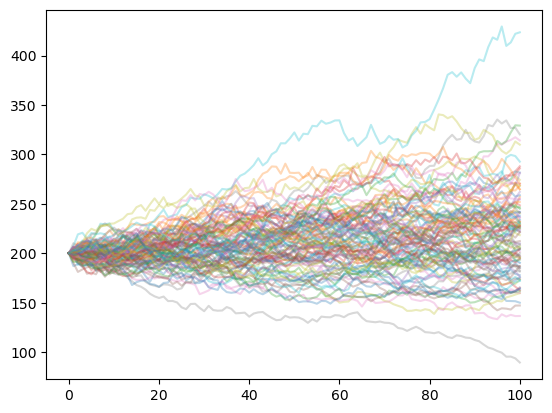

In [656]:
fig, ax = plt.subplots()
for i in range(0,len(k),1):
    ax.plot(k[i], alpha=0.3)

In [589]:

# alfa = [50]
# for i in range(0,5,1):
#     part1 =  alfa[-1]
#     part2 = (0.05-0.01*(1/2)*0.3**2)*1
#     Z = np.random.normal(0,1)
#     part3 = 0.3*sqrt(0.1)*Z
#     wack =  part1*np.e**(part2+part3)
#     alfa.append(wack)
